You can find the story that goes with this code [right here](http://mimsy.io/sinclair_1_3.html).

## Sinclair DMA Exploration

This JUPYTER notebook explores Nielsen Designated Market Areas (DMAs) in combination with data on the Sinclair Broadcast Group. Here, we will attempt to use Nielson DMAs to document/visualize the spread and growth of Sinclair over the last several decades.

This post mirrors an earlier notebook titled **Sinclair Station Exploration** and uses data generated in that notebook. As in **Sinclair Station Exploration**, I'll assume that the current working directory is a clone of [this github repo](https://github.com/theMimsy/Blog---Sinclair-Broadcast-Group). If you want to find the earlier notebook, you can find it [here](http://mimsy.io/sinclair-station-exploration.html).

To analyze, combine, and graph the DMA/Sinclair data, we'll first load some libraries that we'll need throughout the notebook. These include:

+ `dplyr`: Used for `group_by()`, `filter()`, `summarize()`, and `mutate()` as well as `%>%` pipes.
+ `sp`: The base R library used for manipulating geospatial data.
+ `rgdal`: The R implementation of Frank Warmerdam's Geospatial Data Abstraction Library (GDAL). Allows us to read and manipulate [shapefiles](https://en.wikipedia.org/wiki/Shapefile).
+ `maps`: A very simple R library containing outlines of the USA and USA states. Although we won't be using these, this library also contains world maps, locations of large US cities, and the locations of large world cities.
+ `rjson`: Allows the user to convert [JSON](http://www.json.org/) objects to R data frames.
+ `geojsonio`: A library that allows us to convert spatial data from [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) format to data frames (and vice-versa). We'll need this for plotting since my tool of choice (`ggplot2`) requires clean data frames.
+ `ggplot2`: A flexible plotting tool that generates graphics using a [layered grammar of graphics](http://byrneslab.net/classes/biol607/readings/wickham_layered-grammar.pdf). If you want to know more, I'd recommend spending a bit of time reading through chapters 1 and 2 in [Hadley Wickham's ggplot2 book](http://ms.mcmaster.ca/~bolker/misc/ggplot2-book.pdf).
+ `broom`: Used for cleaning up arbitrary R objects into tidy data frames.
+ `RColorBrewer`: Pretty colors for our graphs.

In [3]:
# Load up some libraries
library(dplyr, warn.conflicts = FALSE)
library(sp)
library(rgdal, warn.conflicts = FALSE)
library(maps)
library(rjson)
library(geojsonio, warn.conflicts = FALSE)
library(ggplot2)
library(broom)
library(stringr)
library(RColorBrewer)

rgdal: version: 1.2-8, (SVN revision 663)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.0.1, released 2015/09/15
 Path to GDAL shared files: C:/Users/dmino/Documents/R/win-library/3.4/rgdal/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: C:/Users/dmino/Documents/R/win-library/3.4/rgdal/proj
 Linking to sp version: 1.2-5 


### Examining the Data

Our first order of business is to identify the data we have available. Our second order of business is to identify what we want to do with that data. 

#### First Order of Business

We have two sources of data for use in this notebook. The first source `sinclair_station_all.csv` contains all the data we cleaned and generated in the previous post called **Sinclair Station Exploration**. As the name implies, this csv file holds information on TV stations owned by Sinclair. The columns of the csv include the station name, transmitter power, location, and the market of the station. Since we already cleaned this data beforehand, we don't need to do any work here.

In [4]:
sinclair_station_all_path <- "sinclair_station_all.csv"
sinclair_station_all_df <- read.csv(sinclair_station_all_path)

In [5]:
head(sinclair_station_all_df)

Market,Station,Channel.RF.,Year,Power.kW,Location,Latitude,Longitude,Year.Start,Year.End
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,21 (28),1995,765,33.484583; -86.807083,33.48458,-86.80708,1995,NA
"Birmingham - Tuscaloosa - Anniston, AL",WABM,68 (36),2001,885,33.484583; -86.807056,33.48458,-86.80706,2001,NA
"Birmingham - Tuscaloosa - Anniston, AL",WDBB,17 (18),1995,NA,,NA,NA,1995,NA
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,58 (40),2014,885,33.484583; -86.807056,33.48458,-86.80706,2014,NA
"Mobile, AL & Pensacola, FL",WEAR-TV,3 (17),1997,1000,30.612611; -87.644889,30.61261,-87.64489,1997,NA
"Mobile, AL & Pensacola, FL",WPMI-TV,15 (15),2012,1000,30.61139; -87.607333,30.61139,-87.60733,2012,NA


The second source of data for this notebook is a modified version of [Simon Zou's D3 visualization of Nielsen's DMAs](http://bl.ocks.org/simzou/6459889). The data resides in `Interactive_DMA_Map/nielsengeo.json` and `Interactive_DMA_Map/nielsentopo.json`. These two files hold essentially the same information, except in slightly different formats. See [geojson vs topojson](https://stackoverflow.com/questions/14740705/difference-between-geojson-and-topojson) for more specifics.

What you'll need to know for this exploration is that we'll be using the more verbose `nielsengeo.json` file and that this file has all of the data necessary to draw the DMAs. We can load it in two ways:

+ As a pure JSON object, using the `fromJSON()` function.
+ As a `SpatialPolygonsDataFrame` using the `geojson_read()` function.

While R does allow us to work with pure JSON, it's much more useful when programming in `javascript` (especially when using `d3`). As such, we'll go with the latter option and create a `SpatialPolygonsDataFrame` object.

In [15]:
# Get the shapefile
dma_geo_path <- "Interactive_DMA_Map/nielsengeo.json"
dma_geo_sh <- geojson_read(dma_geo_path, what = "sp")

In [16]:
head(dma_geo_sh, n = 1) # Show only one Polygon in the DataFrame

An object of class "SpatialPolygonsDataFrame"
Slot "data":
    name latitude tvperc dma                   dma1 cableperc adsperc longitude
662 dma: 32.40435   89.2 662 Abilene-Sweetwater, TX      38.2    51.8 -99.82936

Slot "polygons":
[[1]]
An object of class "Polygons"
Slot "Polygons":
[[1]]
An object of class "Polygon"
Slot "labpt":
[1] -99.80485  32.44001

Slot "area":
[1] 3.550962

Slot "hole":
[1] FALSE

Slot "ringDir":
[1] 1

Slot "coords":
            [,1]     [,2]
 [1,]  -98.66994 31.70139
 [2,]  -99.01090 31.47284
 [3,]  -99.23628 31.48278
 [4,]  -99.31718 31.41073
 [5,]  -99.62925 31.46787
 [6,]  -99.70437 31.57718
 [7,] -100.23604 31.58215
 [8,] -100.23604 32.08148
 [9,] -101.18378 32.08645
[10,] -101.17222 32.96340
[11,] -100.51920 32.96340
[12,] -100.51920 33.39814
[13,]  -99.47322 33.39814
[14,]  -99.47322 32.95594
[15,]  -98.57748 32.95346
[16,]  -98.57748 32.51623
[17,]  -98.47346 32.51375
[18,]  -98.47346 32.30010
[19,]  -98.92422 32.07900
[20,]  -98.66994 31.70139



As you can see from the output above, a `SpatialPolygonsDataFrame` isn't simply a table, but an object containing members (or "slots", in R parlance) that each describe polygons in different ways. For example, the `data` slot contains a list of key-value pairs that provide possible labels for that polygon, the `coords` slot contains a list of points used to draw the polygon, and the `area` slot calculates the enclosed area. 

You can write whole tutorials on how these objects work (and people have), but I'm not going to do that here. Why? Because we'll only need this `SpatialPolygonsDataFrame` for only a little while longer. If you really want to learn more about GIS and spatial objects in R (it's actually kind of cool), try the guides by [Nick Eubank](http://www.nickeubank.com/gis-in-r/) and [Claudia Engel](http://www.rpubs.com/cengel248/172289); these guys do a much better job than I ever could.

Now, to convert the `SpatialPolygonsDataFrame` into a standard R data frame, we make clever use of the `merge()` and `tidy()` functions:

In [12]:
# Convert the shapefile into a csv
dma_geo_sh@data$id <- rownames(dma_geo_sh@data)
dma_geo_df <- merge(tidy(dma_geo_sh), dma_geo_sh@data, by = "id")

Regions defined for each Polygons


In [19]:
head(dma_geo_df)

id,long,lat,order,hole,piece,group,name,latitude,tvperc,dma,dma1,cableperc,adsperc,longitude
500,-70.97725,43.35754,1,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-70.95991,43.54138,2,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.11016,43.50660,3,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.12750,43.57367,4,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.26042,43.57119,5,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.53203,43.76496,6,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301


Tada! This data frame holds basically all the same information as the `Spatial` version above. Here, the `group` column tells us which `long`, `lat` pairs belong to which polygon. The `order` column tells us which order to connect the coordinates in. The `piece` column tells us about DMAs that are made up of multiple polygons (or polygons with holes in them). 

For example, the DMA with `id = 500` (Portland-Auburn, ME), is composed of 34 pieces. Piece 1 has `group = 500.1`, piece 2 has `group = 500.2`, piece 3 has `group = 500.3`, etc.

In [30]:
# Get some pieces of the Portland-Auburn DMA
piece1_df <- dma_geo_df[dma_geo_df$group == 500.1,]
piece2_df <- dma_geo_df[dma_geo_df$group == 500.2,]
piece34_df <- dma_geo_df[dma_geo_df$group == 500.34,]

# Get top three rows from each piece
example_portland_df <- rbind(head(piece1_df, n = 3), 
                             head(piece2_df, n = 3),
                             head(piece34_df, n = 3))
# Print
example_portland_df

,id,long,lat,order,hole,piece,group,name,latitude,tvperc,dma,dma1,cableperc,adsperc,longitude
1,500,-70.97725,43.35754,1,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
2,500,-70.95991,43.54138,2,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
3,500,-71.11016,43.50660,3,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
75,500,-68.82170,44.03078,75,FALSE,2,500.2,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
76,500,-68.89683,44.11524,76,FALSE,2,500.2,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
77,500,-68.90839,44.09537,77,FALSE,2,500.2,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
236,500,-69.68276,43.80968,236,FALSE,34,500.34,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
237,500,-69.68854,43.81713,237,FALSE,34,500.34,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
238,500,-69.68276,43.81713,238,FALSE,34,500.34,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301


We can use `ggplot2` to draw maps if we have data frames with a `group` property. For all following maps, I'll be using the *Albers* map projection with `lat0 = 37.5` and `lat1 = 29.5`. This map projection (unlike the Mercator projection, for example) works best when viewing just the US.

In [34]:
# Set the size of output graphics
library(repr)
options(repr.plot.width=8, repr.plot.height=5)

In [50]:
# Define a function that creates a map using the Albers projection
ggalbers <- function() {
    ggplot() +
    coord_map("albers", lat0 = 37.5, lat1 = 29.5) +
    theme(plot.title = element_text(hjust = 0.1, color="#666666", face="bold", size=20), 
        axis.text = element_blank(), 
        axis.line = element_blank(), 
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        panel.border = element_blank(),
        panel.grid = element_blank(),
        panel.background = element_blank()
    )
}

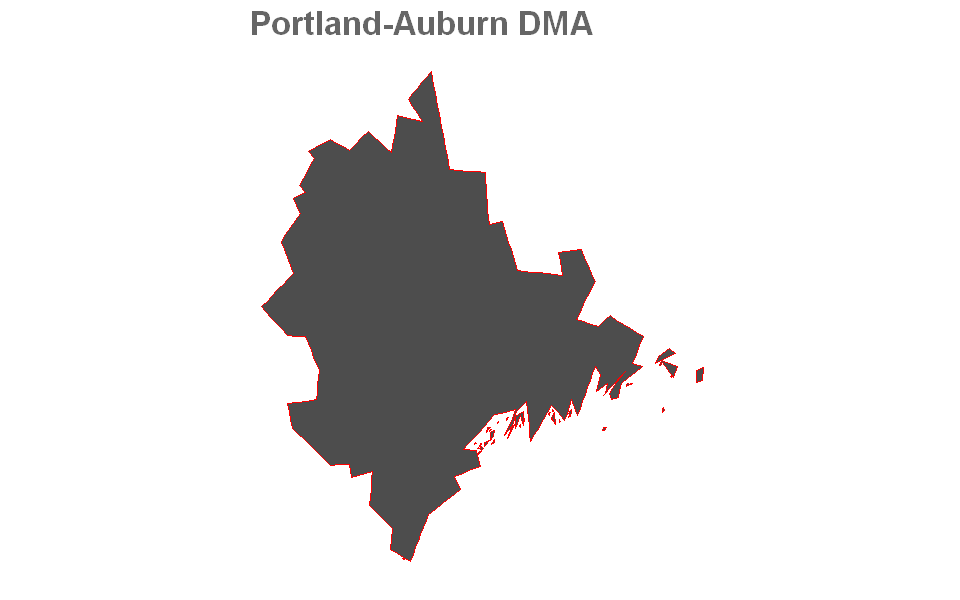

In [51]:
# Get only the Portland-Auburn DMA
dma_portland_df <- dma_geo_df[dma_geo_df$dma == 500,]

# Generate a graph of the Portland-Auburn DMA
ggalbers() +
    geom_polygon(data = dma_portland_df, 
                 color = "red",
                 fill = "gray30",
                 aes(x = long, y = lat, group = group)) +
    ggtitle("Portland-Auburn DMA")

We can now see why this shape had so many pieces: small piece of land floating off in the Atlantic Ocean!

Now that we have a cursory understanding of how to create these maps, let's stop focusing on Maine and consider the entire USA. We can generate some maps for each of the different `properties` such as `tvperc` and `cableperc`, using almost the same code as above:

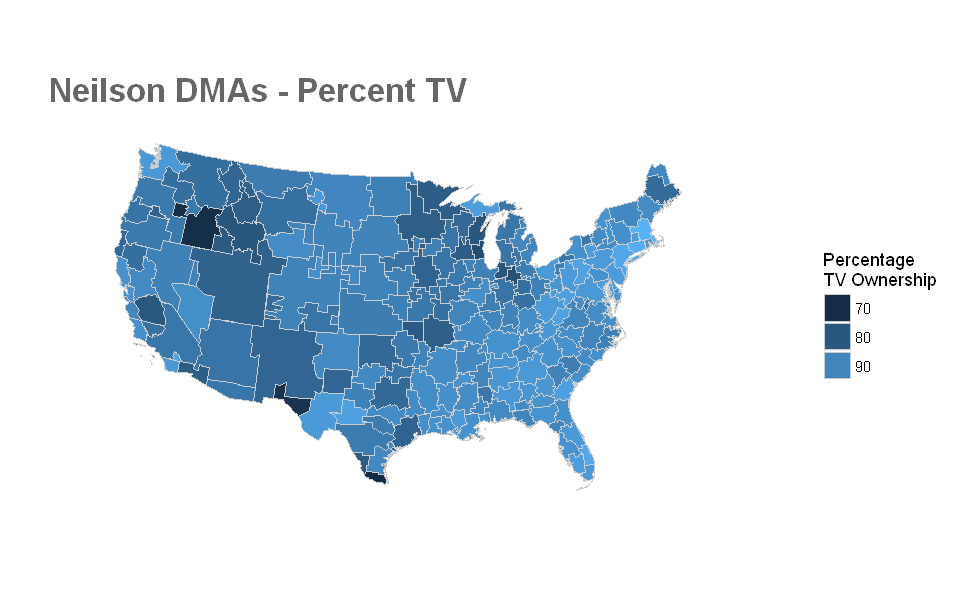

In [49]:
# Generate a map for TV ownership by Neilson market
ggalbers() +
    geom_polygon(data = dma_geo_df, 
                 color = "gray80",
                 aes(x = long, y = lat, group = group, fill = tvperc)) +
    ggtitle("Neilson DMAs - Percent TV") +
    guides(fill = guide_legend(title = "Percentage\nTV Ownership"))

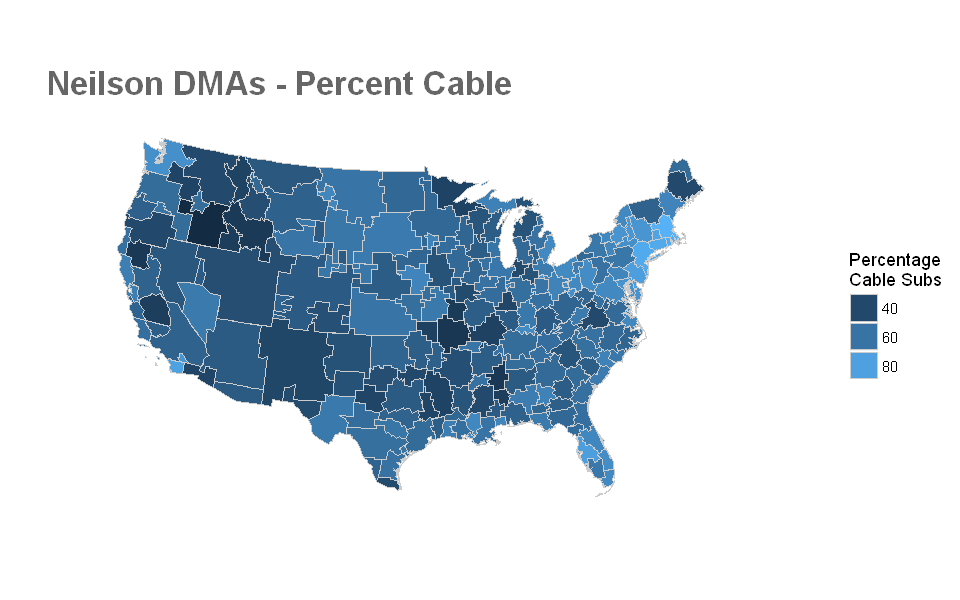

In [52]:
# Generate a map for cable subscriptions by Neilson market
ggalbers() +
    geom_polygon(data = dma_geo_df, 
                 color = "gray80",
                 aes(x = long, y = lat, group = group, fill = cableperc)) +
    ggtitle("Neilson DMAs - Percent Cable") +
    guides(fill = guide_legend(title = "Percentage\nCable Subs"))

#### Second Order of Business

Now that we have a good idea of what the data looks like, what are we going to do with it? Well, we want to answer similar questions to those we answered in **Sinclair Station Exploration**. Namely:

1. How has the number of markets Sincliar operates inside of changed over time?
2. How does the spread of these markets look like spatially, from the viewpoint of the US as a whole?

To do this, we'll need to combine `dma_geo_df` and `sinclair_station_all_df` by matching each station in `sinclair_station_all_df` to their designated market in `dma_geo_df`. Once we do this we'll know which markets Sinclair operates in and when they started that operation. 

How can we do this? If you scroll up you'll see that `sinclair_station_all_df` conveniently has a `Market` column; this should be the obvious method for matching stations with their markets. 

Unfortunately, we won't be able to use this. If you look at the market names in both dataset for a single state (say Illinois), you'll find something like this:

In [10]:
# Show markets in `sinclair_station_all_df` for Illinois
IL_mask <- str_sub(sinclair_station_all_df$Market, start = -2) == "IL"
unique(sinclair_station_all_df[IL_mask, "Market"])

[1] Champaign - Urbana - Decatur - Springfield, IL   
[2] Peoria & Bloomington, IL                         
[3] Cape Girardeau, MO - Paducah, KY - Harrisburg, IL
[4] Hannibal, MO - Quincy, IL                        
114 Levels: Abilene, TX Albany, GA Amarillo, TX Clovis, NM ... Yakima, WA Pasco & Kennewick, WA

In [11]:
# Show markets in `dma_geo_df` for Illinois
IL_mask <- sapply(dma_geo_df$dma1, function(x) grepl("IL", x))
unique(dma_geo_df[IL_mask, "dma1"])

[1] Chicago, IL                                  
[2] Rockford, IL                                 
[3] Paducah, KY-Cape Girardeau, MO-Harrisburg, IL
[4] Champaign & Springfield-Decatur, IL          
[5] Peoria-Bloomington, IL                       
[6] Davenport, IA-Rock Island-Moline, IL         
[7] Quincy, IL-Hannibal, MO-Keokuk, IA           
206 Levels: Abilene-Sweetwater, TX Albany-Schenectady-Troy, NY ... Zanesville, OH

The example above suggests that market names between the two datasets do not seem to match well. Above, we would need to match:

|Sinclair Station Market Name|Nielsen DMA Market Name|
|----------------------------|-----------------------|
|`Champaign - Urbana - Decatur - Springfield, IL`|`Champaign & Springfield-Decatur, IL`|
|`Peoria & Bloomington, IL`|`Peoria-Bloomington, IL`|
|`Cape Girardeau, MO - Paducah, KY - Harrisburg, IL`|`Paducah, KY-Cape Girardeau, MO-Harrisburg, IL`|
|`Hannibal, MO - Quincy, IL`|`Quincy, IL-Hannibal, MO-Keokuk, IA`|
    
While we *can* probably figure this out using a bit of regex engineering, we'll take a different approach in this notebook. To match a Sinclair owned station with its market, we'll look at the location (`Latitude`, `Longitude`) of the station and determine if it's geographically inside of a given market. This method, while initially more difficult, is a lot less error prone than trying to match strings.

#### Merge the Datasets

Remember just a little while ago when I said that we won't need to worry about `dma_geo_sh` because we converted it to a regular data frame called `dma_geo_df`? I may have lied.

There's a function in the spatial library `sp` called `over` (short for "overlay") that takes in two spatial objects (like `dma_geo_sh`) and tells us whether one is inside of another one. This is exactly what we need to find out which stations are inside of which markets! 

It works like this: if we have a list of coordinates called `A` and a list of polygons called `B` then the code `A %over% B` would result in a list that has the same length as `A` and is composed of objects from `B` that enclose each coordinate in `A`.

I think a more concrete example is in order. Lets take a few rows from `sinclair_station_all_df`:

In [65]:
# Get 5 rows from `sinclair_station_all_df`
test_df <- na.omit(sinclair_station_all_df)
test_samples <- sample(1:nrow(test_df), 5)

test_df[test_samples,]

,Market,Station,Channel.RF.,Year,Power.kW,Location,Latitude,Longitude,Year.Start,Year.End
203,"Springfield - Holyoke, MA",WGGB-TV,40 (40),1998-2007,460,42.241667; -72.649167,42.24167,-72.64917,1998,2007
207,"Kansas City, Missouri",KSMO-TV,62 (47),1996-2005,1000,39.090500; -94.472000,39.09050,-94.47200,1996,2005
208,"Plattsburgh, NY - Burlington, VT",WPTZ,5 (14),1997-1998,650,44.52556; -72.81556,44.52556,-72.81556,1997,1998
194,"Colorado Springs - Pueblo, CO",KXRM-TV,21 (22),2013-2014,51,38.745389; -104.860889,38.74539,-104.86089,2013,2014
197,"Tallahassee, FL - Thomasville, GA",WTXL-TV,27 (27),2001-2006,1000,30.66833; -83.96944,30.66833,-83.96944,2001,2006


Next, convert the locationo of each station into a `SpatialPoints` object, which is just a list of `Longitude`, `Latitude` pairs:

In [66]:
# Convert the data frame to a `SpatialPoints` object
test_sh <- SpatialPoints(test_df[test_samples, c("Longitude", "Latitude")])

# Make sure that the projection from `test_sh` is the same as in `dma_geo_sh`
proj4string(test_sh) <- proj4string(dma_geo_sh)

test_sh

SpatialPoints:
     Longitude Latitude
203  -72.64917 42.24167
207  -94.47200 39.09050
208  -72.81556 44.52556
194 -104.86089 38.74539
197  -83.96944 30.66833
Coordinate Reference System (CRS) arguments: +proj=longlat +datum=WGS84
+no_defs +ellps=WGS84 +towgs84=0,0,0 

Finally, use the `over()` function see which DMAs belong to which station:

In [67]:
results_df <- test_sh %over% dma_geo_sh
results_df

,name,latitude,tvperc,dma,dma1,cableperc,adsperc,longitude
203,dma:,42.38569,94.8,543,"Springfield-Holyoke, MA",81.5,14.0,-72.60171
207,dma:,39.30423,87.2,616,"Kansas City, MO",62.7,24.7,-94.20899
208,dma:,44.07130,90.8,523,"Burlington, VT-Plattsburgh, NY",52.5,38.7,-73.03687
194,dma:,38.06138,86.5,752,"Colorado Springs-Pueblo, CO",43.6,43.5,-104.02717
197,dma:,30.46230,93.0,530,"Tallahassee, FL-Thomasville, GA",55.1,38.6,-83.67571


Hey, it works! The column `dma1` (the DMA names) from `results_df` matches the `Market` column from `test_df`. And best of all, we didn't need to loop through every DMA polygon and check whether the station we're currently looking at is inside; all of that was done for us.

Now, we can define a function that will repeat the work above:

In [71]:
# A function that looks through `geo_sh` (list of polygons) for the first polygon that
# contains the coordinates in `lon` and `lat`. Once found, it extracts the wanted attribute.
attribute_of_locations <- function(geo_sh, lon, lat, attribute) {
    
    # Turn `lon`, `lat` into a `SpatialPoints` object
    points_sh <- SpatialPoints(cbind(lon, lat))
    proj4string(points_sh) <- proj4string(geo_sh)
    
    # Overlay `points_sh` on top of `geo_sh`
    results_df <- points_sh %over% geo_sh
    
    results_df[,attribute]
}

The `attribute_of_locations()` function takes a list of coordinates (in the form of two separate vectors `lon` and `lat`), and for each coordinate, it finds the polygon inside of `geo_sh` that contains the coordinate. After finding the polygon, i it extracts the wanted attribute from that polygon.

Onto the long awaited moment! We will use `attrubute_of_locations()` to merge our Sinclair station data and our Nielsen DMA data. The functions `filter()` and `mutate()` will be useful:

In [75]:
sinclair_station_dma_df <- sinclair_station_all_df %>% 
    select(c("Market", "Station", "Latitude", "Longitude", "Year.Start", "Year.End")) %>%
    filter(!is.na(Latitude) & !is.na(Longitude)) %>%
    mutate(DMA = attribute_of_locations(dma_geo_sh, Longitude, Latitude, "dma1")) %>%
    mutate(DMA.Code = attribute_of_locations(dma_geo_sh, Longitude, Latitude, "dma"))

In [76]:
head(sinclair_station_dma_df)

Market,Station,Latitude,Longitude,Year.Start,Year.End,DMA,DMA.Code
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,33.48458,-86.80708,1995,NA,"Birmingham (Anniston and Tuscaloosa), AL",630
"Birmingham - Tuscaloosa - Anniston, AL",WABM,33.48458,-86.80706,2001,NA,"Birmingham (Anniston and Tuscaloosa), AL",630
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,33.48458,-86.80706,2014,NA,"Birmingham (Anniston and Tuscaloosa), AL",630
"Mobile, AL & Pensacola, FL",WEAR-TV,30.61261,-87.64489,1997,NA,"Mobile, AL-Pensacola (Ft. Walton Beach), FL",686
"Mobile, AL & Pensacola, FL",WPMI-TV,30.61139,-87.60733,2012,NA,"Mobile, AL-Pensacola (Ft. Walton Beach), FL",686
"Mobile, AL & Pensacola, FL",WFGX,30.61261,-87.64489,2001,NA,"Mobile, AL-Pensacola (Ft. Walton Beach), FL",686


Now we have an association from each Sinclair TV station to one particular DMA. This is all we need to start answering our questions.

### Graphs and Analysis

Let's start our analysis by trying to answer question **1**; that is, how many markets has Sinclair operated in over time? Using our merged dataset, we need to look at each DMA and find all the times when Sinclair had at least one station operating. The code below, using `group_by()`, approximates this.

In [77]:
sinclair_dma_df <- sinclair_station_dma_df %>% 
    group_by(DMA, DMA.Code) %>%
    summarize(Year.Start = min(Year.Start), Year.End = max(Year.End))

In [78]:
head(sinclair_dma_df)

DMA,DMA.Code,Year.Start,Year.End
"Abilene-Sweetwater, TX",662,2017,NA
"Albany-Schenectady-Troy, NY",532,2012,NA
"Albany, GA",525,2013,NA
"Amarillo, TX",634,2013,NA
"Austin, TX",635,2012,NA
"Bakersfield, CA",800,2013,NA


In [22]:
dma_attributes_path <- "Interactive_DMA_Map/tv_2017.csv"
dma_attributes_df <- read.csv(dma_attributes_path)
colnames(dma_attributes_df) <- c("DMA.Code", "Rank", "DMA", "TV.Homes", "Percent.of.US")

In [23]:
head(dma_attributes_df)

DMA.Code,Rank,DMA,TV.Homes,Percent.of.US
662,165,Abilene-Sweetwater,"113,080",0.099
525,152,"Albany, GA","142,800",0.125
532,59,Albany-Schenectady-Troy,"529,120",0.461
790,48,Albuquerque-Santa Fe,"677,590",0.591
644,179,"Alexandria, LA","85,560",0.075
583,208,Alpena,"16,010",0.014


In [24]:
sinclair_dma_attr_df <- merge(dma_attributes_df[c("DMA.Code", "TV.Homes", "Percent.of.US")], 
                              sinclair_dma_df[c("DMA.Code", "Year.Start", "Year.End")], 
                              by = "DMA.Code")
sinclair_dma_attr_df$TV.Homes <- gsub(",", "", sinclair_dma_attr_df$TV.Homes)
sinclair_dma_attr_df$TV.Homes <- as.numeric(as.character(sinclair_dma_attr_df$TV.Homes))
head(sinclair_dma_attr_df)

DMA.Code,TV.Homes,Percent.of.US,Year.Start,Year.End
500,383700,0.335,NA,NA
503,232910,0.203,2014,NA
507,340050,0.296,2014,NA
508,1160220,1.012,1991,NA
511,2476680,2.159,2014,NA
512,1119480,0.976,1971,NA


In [25]:
sapply(sinclair_dma_attr_df, class)

DMA.Code      TV.Homes Percent.of.US    Year.Start      Year.End 
    "integer"     "numeric"     "numeric"     "numeric"     "numeric"

In [26]:
# Get temporal limits of the data
max_year <- max(sinclair_dma_attr_df$Year.Start, na.rm = TRUE)
min_year <- min(sinclair_dma_attr_df$Year.Start, na.rm = TRUE)

# Get rid of data that has missing year values
no_na_year_df <- sinclair_dma_attr_df %>% filter(!is.na(Year.Start))

# Create aliases for the two year columns
start_year <- no_na_year_df$Year.Start
end_year <- no_na_year_df$Year.End

# Make a new data.frame and fill it using a for-loop
# This is a slow way to do it but our dataset is not huge 
sinclair_population_df <- data.frame()
for(year in min_year:max_year) {
    # Generate the station count
    # Remember to take care of possible NA values in `end_year`
    new_row <- sinclair_dma_attr_df %>%
        filter( Year.Start <= year & (Year.End >= year | is.na(Year.End)) ) %>%
        summarize(TV.Homes.Tot = sum(TV.Homes), Percent.of.US.Tot = sum(Percent.of.US))
    new_row$Year = c(year)
    sinclair_population_df <- rbind(sinclair_population_df, new_row)
}

In [27]:
sinclair_population_df[sample(1:nrow(sinclair_population_df), 5),]

,TV.Homes.Tot,Percent.of.US.Tot,Year
30,25234410,22.001,2000
2,1119480,0.976,1972
17,2040220,1.779,1987
21,5109030,4.455,1991
26,14184640,12.368,1996


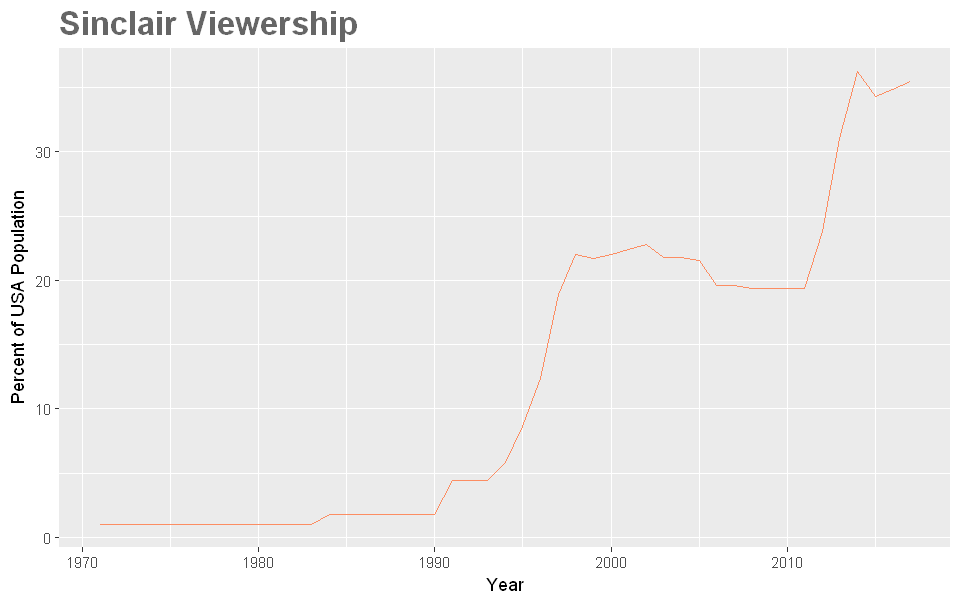

In [46]:
# Create the plot
sinclair_population_plot <- ggplot(data = sinclair_population_df) +
    geom_line(aes(x = Year, y = Percent.of.US.Tot), color = brewer.pal(3, "Set2")[2]) +
    ggtitle("Sinclair Viewership") + 
    xlab("Year") + ylab("Percent of USA Population") +
    theme(plot.title = element_text(color="#666666", face="bold", size=20))

sinclair_population_plot

As we can see, this plot shows a very similar story compared to its earlier counterpart in **Sinclair Station Exploration**. Points of highest slope appear during large acquisitions in the mid-90s and 2011-2013. The last 5 years contain the all-time maximum:

In [43]:
tail(sinclair_population_df$Percent.of.US.Tot, n = 5)

[1] 31.055 36.287 34.314 34.828 35.494

In [29]:
max(sinclair_population_df$Percent.of.US.Tot)

[1] 36.287

So, currently, Sinclair Broadcast delivers local news to 35.494% of the US population. This number was highest in 2014 with a value of 36.287%.

In [30]:
max(sinclair_population_df$TV.Homes.Tot)

[1] 41619730

Nielson estimates the total number of TV homes for the 2016-2017 period is 118.4 million. Using this we number we validate our previous estimate because 41,619,730 / 118,400,000 = 0.3515 = 35.15%. The numbers differ slightly because not every "TV Home" will have the same number of people in it.

In [31]:
head(dma_geo_df)

id,long,lat,order,hole,piece,group,name,latitude,tvperc,dma,dma1,cableperc,adsperc,longitude
500,-70.97725,43.35754,1,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-70.95991,43.54138,2,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.11016,43.50660,3,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.12750,43.57367,4,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.26042,43.57119,5,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.53203,43.76496,6,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301


In [32]:
sinclair_final_df <- merge(sinclair_dma_df, dma_geo_df, by.x = "DMA", by.y = "dma1")
sinclair_final_df <- sinclair_final_df %>%
    select(DMA, id, long, lat, order, hole, piece, group, Year.Start, Year.End)
sinclair_final_df <- sinclair_final_df[order(sinclair_final_df$id, sinclair_final_df$order),]

In [33]:
head(sinclair_final_df) 

,DMA,id,long,lat,order,hole,piece,group,Year.Start,Year.End
3227,"Portland-Auburn, ME",500,-70.97725,43.35754,1,FALSE,1,500.1,NA,NA
3167,"Portland-Auburn, ME",500,-70.95991,43.54138,2,FALSE,1,500.1,NA,NA
3316,"Portland-Auburn, ME",500,-71.11016,43.50660,3,FALSE,1,500.1,NA,NA
3277,"Portland-Auburn, ME",500,-71.12750,43.57367,4,FALSE,1,500.1,NA,NA
3278,"Portland-Auburn, ME",500,-71.26042,43.57119,5,FALSE,1,500.1,NA,NA
3209,"Portland-Auburn, ME",500,-71.53203,43.76496,6,FALSE,1,500.1,NA,NA


In [34]:
plot_sinclair_dmas <- function(year) {
    # Separate the spatial data into four datasets
    plot_df <- sinclair_final_df %>%
        mutate(Acquired = case_when(
            (Year.Start < year) & (Year.End > year | is.na(Year.End)) ~ "acquired\nprevious years",
            Year.Start == year ~ "acquired\nthis year",
            Year.End == year ~ "sold\nthis year",
            TRUE ~ "not held")
        )
    
    # We don't want to show the DMAs that were not held during the given year
    held_mask <- plot_df$Acquired != "not held"
    plot_df <- plot_df[held_mask, ]
    factor_levels <- c("acquired\nprevious years", "acquired\nthis year", "sold\nthis year")
    plot_df$Acquired <- factor(plot_df$Acquired, levels = factor_levels)
    
    # Pick some nice colors
    nice_colors <- brewer.pal(3, "Set2")
    
    # Make the plot
    ggplot() +
        coord_map("albers", lat0 = 37.5, lat1 = 29.5) + 
        geom_polygon(data = dma_geo_df,
                     aes(x = long, y = lat, group = group),
                     color = "gray60") +
        geom_polygon(data = plot_df,
                     aes(x = long, y = lat, group = group, fill = Acquired),
                     color = "gray60") +
        scale_fill_manual(values = nice_colors, drop = FALSE) +
        theme(plot.title = element_text(hjust = 0.1, color="#666666", face="bold", size=20), 
            axis.text = element_blank(), 
            axis.line = element_blank(), 
            axis.ticks = element_blank(),
            axis.title = element_blank(),
            panel.border = element_blank(),
            legend.position = c(0.93, 0.5),
            legend.key.size = unit(1, "cm"),
            legend.text = element_text(size=12),
            legend.title = element_text(size=12),
            panel.grid = element_blank(),
            panel.background = element_blank()) +
        ggtitle(paste("Sinclair DMAs in", year))
}

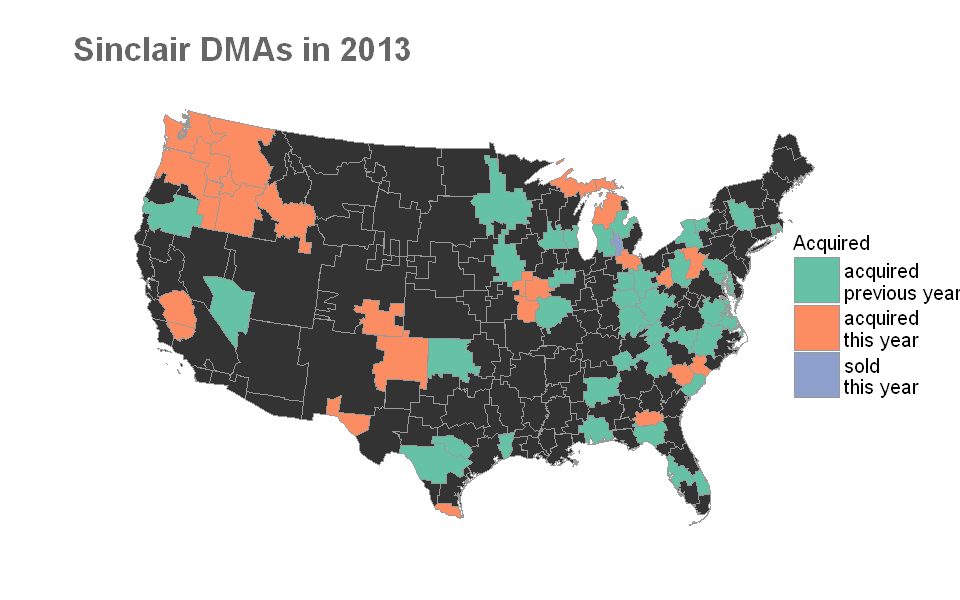

In [35]:
plot_sinclair_dmas(2013)

In [47]:
IMAGE_OUTPUT_PATH <- "Images"

In [48]:
ggsave(filename = 'Sinclair_Viewership.png', 
    plot = sinclair_population_plot,
    path = IMAGE_OUTPUT_PATH,
    width = unit(8, "cm"),
    height = unit(5, "cm"))

In [ ]:
max_year <- max(sinclair_final_df$Year.Start, na.rm = TRUE)
min_year <- min(sinclair_final_df$Year.Start, na.rm = TRUE)

for(year in min_year:max_year) {
    image <- plot_sinclair_dmas(year)
    image.name <- paste("Sinclair_DMAs", year, sep = "_")
    image.name <- paste(image.name, ".png", sep = "")
    ggsave(filename = image.name, 
        plot = image,
        path = IMAGE_OUTPUT_PATH,
        width = unit(14, "cm"),
        height = unit(10, "cm"))
}